In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim
import matplotlib.pyplot as plt
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')
sys.path.append("/content/drive/MyDrive/Diplom/")

Mounted at /content/drive


In [4]:
from mpt import markowitz_optimization_pytorch

Making dataframes to look like I want. With date as indexes n shit, keeping only data starting form 2016-01-01, because thats what is in con_df and removing ".close" from column names.

In [5]:
agg_df = pd.read_csv("/content/drive/MyDrive/Diplom/data/close_aggregated_adjusted.csv")

# Converting 'date' to datetime
agg_df["date"] = pd.to_datetime(agg_df["date"], errors="coerce")

# Set 'date' as index
agg_df.set_index("date", inplace=True)

# Keeping data from 2016-01-01 to the end
agg_df = agg_df.loc["2016-01-01":]

In [6]:
# Filling missing values
agg_df =  agg_df.ffill().bfill().dropna()

In [7]:
agg_df.columns = agg_df.columns.str.replace('.close', '', regex=False)

In [8]:
con_df = pd.read_csv("/content/drive/MyDrive/Diplom/data/constituents_by_date.csv")

# Converting 'date' to datetime
con_df["date"] = pd.to_datetime(con_df["date"], errors="coerce")

# Set 'date' as index
con_df.set_index("date", inplace=True)

In [9]:
# Converting 'constituents' to pd.Index
con_df["constituents"] = con_df["constituents"].apply(lambda x: pd.Index(eval(x)))

In [10]:
agg_df

,APC,EA,JEF,RTX,GWW,COO,GAS,PLD,GEN,LW,...,SCHW,XL,MRNA,EXC,VTR,FI,WTW,BHF,PRU,LDOS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,47.3662,65.0032,11.6786,49.8420,175.7660,131.6200,63.76,34.0834,8.4090,31.1131,...,29.1055,9.79,18.60,15.2856,39.9370,41.4939,112.0205,70.00,56.8596,34.6968
2016-01-05,46.7781,63.8624,11.7060,49.9202,173.6441,131.3405,64.00,34.7993,8.4252,31.1131,...,29.0145,9.79,18.60,15.3894,40.6408,41.6840,112.7915,70.00,56.6673,35.4019
2016-01-06,42.1986,62.6233,11.5276,48.5643,173.0963,131.3505,63.85,34.6122,8.4131,31.1131,...,28.0224,9.79,18.60,15.4058,40.2678,41.3688,107.5392,70.00,54.7801,34.7930
2016-01-07,38.6700,61.4236,11.3561,47.9280,171.4266,127.7271,63.43,33.7093,8.2718,31.1131,...,26.5571,9.79,18.60,15.2145,39.5639,40.8959,103.0307,70.00,52.5510,33.9340
2016-01-08,39.1039,62.0825,10.9512,47.1458,169.3917,128.4757,63.17,33.4083,8.2678,31.1131,...,26.3933,9.79,18.60,15.2036,39.5991,40.5806,104.5276,70.00,52.0240,33.6969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-05,72.7700,121.5000,36.4100,85.0500,693.0100,352.2100,65.97,122.0500,20.6100,96.8600,...,59.6800,1.20,109.36,39.5100,42.2500,121.8100,204.1200,48.61,94.4500,97.4600
2023-09-06,72.7700,120.9000,36.8400,83.5100,693.5400,356.6500,65.97,121.3800,20.2400,96.7300,...,58.2700,1.20,108.24,39.8600,42.6400,122.5000,204.5400,49.36,94.3200,96.5100
2023-09-07,72.7700,120.9400,36.5800,84.3300,691.7900,353.7400,65.97,123.3100,20.0000,98.3800,...,57.8200,1.20,108.35,40.5700,42.5900,123.1000,203.8600,48.88,94.2800,95.7400


In [11]:
con_df

,constituents
date,
2016-01-01,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-04-01,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-07-01,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."
2016-10-01,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."
2017-01-01,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."
2017-04-01,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."
2017-07-01,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."
2017-10-01,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."
2018-01-01,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."


In [12]:
# How to access to lists in con_df
con_df.constituents.iloc[0]

Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY', 'MCD', 'HD', 'TWC', 'SPG',
       ...
       'LUMN', 'NRG', 'LMT', 'VAL', 'PSX', 'FLIR', 'SCHW', 'LVLT', 'J', 'AVY'],
      dtype='object', length=505)

In [13]:
con_df.shape

(36, 1)

In [14]:
con_df.index

DatetimeIndex(['2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01',
               '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01',
               '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01',
               '2023-01-01', '2023-04-01', '2023-07-01', '2023-10-01',
               '2023-11-24', '2024-02-29', '2024-05-31', '2024-06-09'],
              dtype='datetime64[ns]', name='date', freq=None)

In [15]:
agg_df.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2023-08-28', '2023-08-29', '2023-08-30', '2023-08-31',
               '2023-09-01', '2023-09-05', '2023-09-06', '2023-09-07',
               '2023-09-08', '2023-09-11'],
              dtype='datetime64[ns]', name='date', length=1935, freq=None)

Im gonna add rows to con_df, such that it includes every date from 2016-01-01 to 2024-06-09. Even tho, with current agg_df I will need only data till 2023-09-11. Then Im gonna keep only dates, that are present in con_df (some dates are just missing).

In [16]:
for i in range(len(con_df.index)):
    for dt in pd.date_range(start=con_df.index[i], end=con_df.index[i + 1] - pd.Timedelta(days=1)):
        if dt not in con_df.index:  # Check if the index does not exist
            con_df.loc[dt] = con_df.loc[con_df.index[i]]  # Add a new row with the same values as the current index

In [17]:
con_df = con_df.sort_index()

In [18]:
con_df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03',
               '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07',
               '2024-06-08', '2024-06-09'],
              dtype='datetime64[ns]', name='date', length=3083, freq=None)

In [19]:
# Keeping only dates that are in agg_df (some of the dates are just missing)
con_df = con_df.loc[con_df.index.intersection(agg_df.index)]

In [20]:
con_df.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2023-08-28', '2023-08-29', '2023-08-30', '2023-08-31',
               '2023-09-01', '2023-09-05', '2023-09-06', '2023-09-07',
               '2023-09-08', '2023-09-11'],
              dtype='datetime64[ns]', name='date', length=1935, freq=None)

Now, that I have all the right dataframes, Im gonna do Rolling Markowitz on agg_df, but using only assets from SnP500. Im gonna use markowitz_optimization_pytorch from mpt.py.

In [61]:
#Keeping smaller, 1 year data
smaller_agg_df = agg_df.iloc[:]
smaller_con_df = con_df.loc[:smaller_agg_df.index[-1]]
#Returns dataframe
returns = ((smaller_agg_df - smaller_agg_df.shift(1)) / smaller_agg_df.shift(1)).iloc[1:]

In [62]:
returns

,APC,EA,JEF,RTX,GWW,COO,GAS,PLD,GEN,LW,...,SCHW,XL,MRNA,EXC,VTR,FI,WTW,BHF,PRU,LDOS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.012416,-0.017550,0.002346,0.001569,-0.012072,-0.002124,0.003764,0.021004,0.001927,0.000000,...,-0.003127,0.0,0.000000,0.006791,0.017623,0.004581,0.006883,0.000000,-0.003382,0.020322
2016-01-06,-0.097898,-0.019403,-0.015240,-0.027161,-0.003155,0.000076,-0.002344,-0.005377,-0.001436,0.000000,...,-0.034193,0.0,0.000000,0.001066,-0.009178,-0.007562,-0.046566,0.000000,-0.033303,-0.017200
2016-01-07,-0.083619,-0.019157,-0.014877,-0.013102,-0.009646,-0.027586,-0.006578,-0.026086,-0.016795,0.000000,...,-0.052290,0.0,0.000000,-0.012417,-0.017480,-0.011431,-0.041924,0.000000,-0.040692,-0.024689
2016-01-08,0.011221,0.010727,-0.035655,-0.016320,-0.011870,0.005861,-0.004099,-0.008929,-0.000484,0.000000,...,-0.006168,0.0,0.000000,-0.000716,0.000890,-0.007710,0.014529,0.000000,-0.010028,-0.006987
2016-01-11,-0.069282,0.017106,-0.003753,0.001107,-0.029108,-0.008158,0.009023,-0.001218,-0.006350,0.000000,...,-0.008964,0.0,0.000000,0.008630,0.005690,0.004685,-0.014149,0.000000,-0.002191,0.003994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-05,0.000000,0.007964,0.001926,-0.014256,-0.025001,-0.034221,0.000000,-0.020387,0.006839,-0.004317,...,-0.013554,0.0,-0.028429,-0.012003,-0.019266,-0.008143,-0.018040,-0.049658,-0.017067,-0.013962
2023-09-06,0.000000,-0.004938,0.011810,-0.018107,0.000765,0.012606,0.000000,-0.005490,-0.017952,-0.001342,...,-0.023626,0.0,-0.010241,0.008859,0.009231,0.005665,0.002058,0.015429,-0.001376,-0.009748
2023-09-07,0.000000,0.000331,-0.007058,0.009819,-0.002523,-0.008159,0.000000,0.015900,-0.011858,0.017058,...,-0.007723,0.0,0.001016,0.017812,-0.001173,0.004898,-0.003325,-0.009724,-0.000424,-0.007978


In [32]:
smaller_con_df

,constituents
date,
2016-01-04,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-01-05,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-01-06,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-01-07,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-01-08,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
...,...
2017-06-08,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."
2017-06-09,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."
2017-06-12,"Index(['CHRW', 'AJG', 'CNP', 'WM', 'PRGO', 'BA..."


In [55]:
smaller_con_df.constituents

,constituents
date,
2016-01-04,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-01-05,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-01-06,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-01-07,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
2016-01-08,"Index(['CHRW', 'CNP', 'WM', 'PRGO', 'BA', 'WY'..."
...,...
2020-05-11,"Index(['CHRW', 'AJG', 'CNP', 'AMCR', 'WM', 'PR..."
2020-05-12,"Index(['CHRW', 'AJG', 'CNP', 'AMCR', 'WM', 'PR..."
2020-05-13,"Index(['CHRW', 'AJG', 'CNP', 'AMCR', 'WM', 'PR..."


Setting asset return values to 0 for stocks that arent in S&P-500 at current date.

In [63]:
membership_mask = pd.DataFrame(0, index=smaller_con_df.index, columns=returns.columns)

for date in smaller_con_df.index:
    if date in membership_mask.index:
        membership_mask.loc[date] = membership_mask.columns.isin(smaller_con_df.loc[date, 'constituents']).astype(int)

In [35]:
membership_mask

,APC,EA,JEF,RTX,GWW,COO,GAS,PLD,GEN,LW,...,SCHW,XL,MRNA,EXC,VTR,FI,WTW,BHF,PRU,LDOS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,1,1,1,1,1,0,1,1,1,0,...,1,1,0,1,1,1,0,0,1,0
2016-01-05,1,1,1,1,1,0,1,1,1,0,...,1,1,0,1,1,1,0,0,1,0
2016-01-06,1,1,1,1,1,0,1,1,1,0,...,1,1,0,1,1,1,0,0,1,0
2016-01-07,1,1,1,1,1,0,1,1,1,0,...,1,1,0,1,1,1,0,0,1,0
2016-01-08,1,1,1,1,1,0,1,1,1,0,...,1,1,0,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-08,1,1,1,1,1,1,0,1,1,0,...,1,1,0,1,1,1,1,0,1,0
2017-06-09,1,1,1,1,1,1,0,1,1,0,...,1,1,0,1,1,1,1,0,1,0
2017-06-12,1,1,1,1,1,1,0,1,1,0,...,1,1,0,1,1,1,1,0,1,0


In [64]:
adjusted_returns = returns * membership_mask.iloc[1:]

In [59]:
adjusted_returns

,APC,EA,JEF,RTX,GWW,COO,GAS,PLD,GEN,LW,...,SCHW,XL,MRNA,EXC,VTR,FI,WTW,BHF,PRU,LDOS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.012416,-0.017550,0.002346,0.001569,-0.012072,-0.000000,0.003764,0.021004,0.001927,0.000000,...,-0.003127,0.0,0.0,0.006791,0.017623,0.004581,0.000000,0.0,-0.003382,0.000000
2016-01-06,-0.097898,-0.019403,-0.015240,-0.027161,-0.003155,0.000000,-0.002344,-0.005377,-0.001436,0.000000,...,-0.034193,0.0,0.0,0.001066,-0.009178,-0.007562,-0.000000,0.0,-0.033303,-0.000000
2016-01-07,-0.083619,-0.019157,-0.014877,-0.013102,-0.009646,-0.000000,-0.006578,-0.026086,-0.016795,0.000000,...,-0.052290,0.0,0.0,-0.012417,-0.017480,-0.011431,-0.000000,0.0,-0.040692,-0.000000
2016-01-08,0.011221,0.010727,-0.035655,-0.016320,-0.011870,0.000000,-0.004099,-0.008929,-0.000484,0.000000,...,-0.006168,0.0,0.0,-0.000716,0.000890,-0.007710,0.000000,0.0,-0.010028,-0.000000
2016-01-11,-0.069282,0.017106,-0.003753,0.001107,-0.029108,-0.000000,0.009023,-0.001218,-0.006350,0.000000,...,-0.008964,0.0,0.0,0.008630,0.005690,0.004685,-0.000000,0.0,-0.002191,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-11,0.000000,0.006431,-0.000000,-0.022328,0.003994,0.010837,0.000000,-0.012115,0.010339,-0.030550,...,-0.018351,0.0,0.0,-0.004007,-0.035216,-0.029109,0.013428,-0.0,-0.032724,-0.006135
2020-05-12,0.000000,-0.008520,-0.000000,-0.011159,-0.032730,-0.013969,0.000000,-0.052431,-0.032556,-0.023968,...,-0.042412,0.0,-0.0,-0.012074,-0.044076,-0.014352,0.003950,-0.0,-0.048903,-0.021162
2020-05-13,0.000000,0.004554,-0.000000,-0.046192,-0.014934,-0.023392,0.000000,-0.016385,-0.017790,-0.059248,...,-0.034088,0.0,0.0,-0.031221,-0.034944,-0.014062,-0.018029,-0.0,-0.053630,-0.044039


[1.         1.00430958 1.0057841  ...        nan        nan        nan]


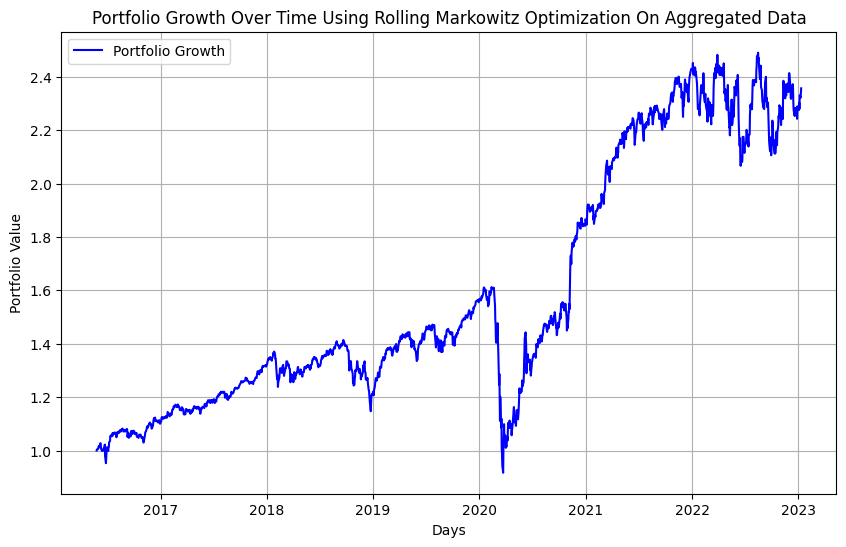

In [65]:
# Portfolio value tracking
portfolio_value = [1]  # Start with 1

# Rolling window Markowitz portfolio simulation
window_size = 100  # Use past 100 days of returns

for t in range(window_size, len(adjusted_returns)):

    # Choosing part of dataframe to feed markowitz
    columns_to_keep = smaller_con_df.iloc[t - window_size].constituents.append(smaller_con_df.iloc[t - window_size + 1: t].constituents.tolist()).unique()
    columns_to_keep = columns_to_keep.intersection(adjusted_returns.columns)  # Retain only columns that exist in returns
    temp_df = adjusted_returns.copy().loc[:, columns_to_keep].iloc[t - window_size: t]  # Filter returns to keep only the relevant columns

    # Feeding markowitz
    temp_weights = markowitz_optimization_pytorch(temp_df, temp_df.mean().mean()).cpu().detach().numpy()

    # Doing the dot product part, but considering that we have to set some weights to 0, for some assets to not have effect
    temp_dict = dict(zip(columns_to_keep, temp_weights))

    for key in adjusted_returns.columns:
        if key not in temp_dict:
            temp_dict[key] = 0

    next_day_return = sum(pd.Series(temp_dict) * adjusted_returns.iloc[t])

    # Update portfolio value
    portfolio_value.append(portfolio_value[-1] * (1 + next_day_return))

# Convert to numpy array for easier plotting
portfolio_value = np.array(portfolio_value)

print(portfolio_value)
# Plot portfolio growth
plt.figure(figsize=(10, 6))
plt.plot(adjusted_returns.index[window_size - 1:], portfolio_value, label='Portfolio Growth', color='blue')
plt.title("Portfolio Growth Over Time Using Rolling Markowitz Optimization On Aggregated Data")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
# plt.ylim(0.9999, 1.000001)
plt.legend()
plt.grid(True)
plt.show()